## Import Libraries

In [12]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

## Rading Data

In [2]:
class FeatureDataset(Dataset):
    def __init__(self, data_path):
        self.data = torch.load(data_path) 
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image_feature = item['image_features'].squeeze(0)
        label = item['label']
        
        return image_feature, torch.tensor(label, dtype=torch.long)

In [3]:
train_dataset = FeatureDataset('./entry_data/train_data.pt')
valid_dataset = FeatureDataset('./entry_data/valid_data.pt')
test_dataset  = FeatureDataset('./entry_data/test_data.pt')


train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_dataloader  = DataLoader(test_dataset,  batch_size=64, shuffle=False)


C:\Users\moah\AppData\Local\Temp\ipykernel_22656\1174989720.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data = torch.load(data_path)


## network

In [25]:
class ProjectionModel(nn.Module):
    def __init__(self, input_dim, projection_dim=256, dropout_rate=0.2):
        super().__init__()
        
        self.advanced_head = nn.Sequential(
            nn.Linear(input_dim, input_dim * 2),
            nn.GELU(),
            nn.LayerNorm(input_dim * 2),
            nn.Dropout(dropout_rate),
            nn.Linear(input_dim * 2, input_dim),
            nn.GELU(),
            nn.LayerNorm(input_dim),
            nn.Dropout(dropout_rate),
            nn.Linear(input_dim, projection_dim)
        )
    def forward(self, features):
        return self.advanced_head(features)

In [27]:
class SharedProjectionModel(nn.Module):
    def __init__(self, image_dim=1024, text_dim=768, projection_dim=256):
        super().__init__()
        self.image_head = ProjectionModel(image_dim, projection_dim)
        self.text_head = ProjectionModel(text_dim, projection_dim)

    def forward(self, image_features, text_features):
        image_projection = self.image_head(image_features)
        text_projection = self.text_head(text_features)
        
        return image_projection, text_projection


## Training Faze

In [29]:
def plot_history(history):
    print("\n--- Plotting Training History ---")
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy History')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [30]:
class GlobalTripletLoss(nn.Module):
    def __init__(self, margin=0.2):
        super().__init__()
        self.margin = margin

    def forward(self, image_proj, all_text_proj, labels):
     
        image_proj = F.normalize(image_proj, p=2, dim=-1)
        all_text_proj = F.normalize(all_text_proj, p=2, dim=-1)

        positive_text_proj = all_text_proj[labels]
        
        positive_dist = 1 - torch.sum(image_proj * positive_text_proj, dim=1)

        similarity_matrix = image_proj @ all_text_proj.T
        
        similarity_matrix.scatter_(1, labels.unsqueeze(1), -float('inf'))
        
        hard_negative_indices = torch.argmax(similarity_matrix, dim=1)
        
        negative_text_proj = all_text_proj[hard_negative_indices]
        
        negative_dist = 1 - torch.sum(image_proj * negative_text_proj, dim=1)

        losses = F.relu(positive_dist - negative_dist + self.margin)
        
        return losses.mean()

In [31]:
def global_clip_loss(image_proj, text_proj, labels, temperature=1.0):
    image_proj = F.normalize(image_proj, p=2, dim=-1)
    text_proj = F.normalize(text_proj, p=2, dim=-1)
    logits = (image_proj @ text_proj.T) / temperature
    return F.cross_entropy(logits, labels)

In [32]:
def evaluate(model, dataloader, all_text_features, criterion, device):
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad():
        all_text_proj = model.text_head(all_text_features)
        for img_feats, labels in tqdm(dataloader, desc="Evaluating"):
            img_feats, labels = img_feats.to(device), labels.to(device)
            img_proj = model.image_head(img_feats)
            loss = criterion(img_proj, all_text_proj, labels)
            
            total_loss += loss.item() * img_feats.size(0)
            logits = F.normalize(img_proj) @ F.normalize(all_text_proj).T
            _, preds = torch.max(logits, 1)
            correct_predictions += torch.sum(preds == labels).item()
            total_samples += img_feats.size(0)
    return total_loss / total_samples, correct_predictions / total_samples


In [39]:
def train_model_global(model, train_loader, valid_loader, all_text_features, optimizer, criterion, num_epochs, device,noise_level=0.02):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        model.eval()
        with torch.no_grad():
            all_text_proj = model.text_head(all_text_features)

        model.train()
        train_loss, train_corrects, train_total = 0.0, 0, 0

        for img_feats, labels in tqdm(train_loader, desc=f"[Epoch {epoch+1}] Training"):
            img_feats, labels = img_feats.to(device), labels.to(device)

            optimizer.zero_grad()
            img_feats = img_feats + (torch.randn_like(img_feats) * noise_level)
            img_proj = model.image_head(img_feats)
            
            loss = criterion(img_proj, all_text_proj, labels)
            
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * img_feats.size(0)
            with torch.no_grad():
                logits = (F.normalize(img_proj) @ F.normalize(all_text_proj).T)
                _, preds = torch.max(logits, 1)
                train_corrects += torch.sum(preds == labels).item()
            train_total += img_feats.size(0)

        history['train_loss'].append(train_loss / train_total)
        history['train_acc'].append(train_corrects / train_total)

        val_loss, val_acc = evaluate(model, valid_loader, all_text_features, criterion, device)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {history['train_loss'][-1]:.4f} | Train Acc: {history['train_acc'][-1]:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    return history


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SharedProjectionModel(image_dim=1024, text_dim=768, projection_dim=256).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = global_clip_loss


class_text_features_list = torch.load('./entry_data/gemini-short.pt')
all_text_features = torch.cat([item['text_features'] for item in class_text_features_list]).to(device)

history = train_model_global(model, train_dataloader, valid_dataloader, all_text_features, optimizer, criterion, num_epochs=25, device=device)

C:\Users\moah\AppData\Local\Temp\ipykernel_22656\2289402776.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  class_text_features_list = torch.load('./entry_data/gemini-sh

Epoch 1/25 | Train Loss: 4.1397 | Train Acc: 0.4692 | Val Loss: 4.0540 | Val Acc: 0.5669


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 774.60it/s]


Epoch 2/25 | Train Loss: 4.0316 | Train Acc: 0.6172 | Val Loss: 4.0104 | Val Acc: 0.6217


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 797.74it/s]


Epoch 3/25 | Train Loss: 3.9858 | Train Acc: 0.6874 | Val Loss: 3.9902 | Val Acc: 0.6585


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 772.80it/s]


Epoch 4/25 | Train Loss: 3.9541 | Train Acc: 0.7371 | Val Loss: 3.9762 | Val Acc: 0.6914


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 773.81it/s]


Epoch 5/25 | Train Loss: 3.9298 | Train Acc: 0.7775 | Val Loss: 3.9695 | Val Acc: 0.7038


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 830.98it/s]


Epoch 6/25 | Train Loss: 3.9113 | Train Acc: 0.8093 | Val Loss: 3.9669 | Val Acc: 0.7175


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 788.98it/s]


Epoch 7/25 | Train Loss: 3.8960 | Train Acc: 0.8357 | Val Loss: 3.9634 | Val Acc: 0.7219


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 415.44it/s]


Epoch 8/25 | Train Loss: 3.8844 | Train Acc: 0.8568 | Val Loss: 3.9633 | Val Acc: 0.7263


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 386.71it/s]


Epoch 9/25 | Train Loss: 3.8735 | Train Acc: 0.8759 | Val Loss: 3.9555 | Val Acc: 0.7327


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 290.84it/s]


Epoch 10/25 | Train Loss: 3.8665 | Train Acc: 0.8872 | Val Loss: 3.9607 | Val Acc: 0.7339


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 362.44it/s]


Epoch 11/25 | Train Loss: 3.8590 | Train Acc: 0.9014 | Val Loss: 3.9617 | Val Acc: 0.7361


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 372.24it/s]


Epoch 12/25 | Train Loss: 3.8537 | Train Acc: 0.9113 | Val Loss: 3.9593 | Val Acc: 0.7323


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 372.80it/s]


Epoch 13/25 | Train Loss: 3.8493 | Train Acc: 0.9190 | Val Loss: 3.9589 | Val Acc: 0.7359


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 286.66it/s]


Epoch 14/25 | Train Loss: 3.8452 | Train Acc: 0.9262 | Val Loss: 3.9591 | Val Acc: 0.7345


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 369.45it/s]


Epoch 15/25 | Train Loss: 3.8427 | Train Acc: 0.9315 | Val Loss: 3.9653 | Val Acc: 0.7352


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 366.53it/s]


Epoch 16/25 | Train Loss: 3.8382 | Train Acc: 0.9378 | Val Loss: 3.9672 | Val Acc: 0.7315


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 367.32it/s]


Epoch 17/25 | Train Loss: 3.8364 | Train Acc: 0.9422 | Val Loss: 3.9679 | Val Acc: 0.7312


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 361.76it/s]


Epoch 18/25 | Train Loss: 3.8343 | Train Acc: 0.9462 | Val Loss: 3.9689 | Val Acc: 0.7286


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 336.64it/s]


Epoch 19/25 | Train Loss: 3.8326 | Train Acc: 0.9502 | Val Loss: 3.9713 | Val Acc: 0.7286


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 374.47it/s]


Epoch 20/25 | Train Loss: 3.8303 | Train Acc: 0.9538 | Val Loss: 3.9687 | Val Acc: 0.7303


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 343.95it/s]


Epoch 21/25 | Train Loss: 3.8296 | Train Acc: 0.9543 | Val Loss: 3.9710 | Val Acc: 0.7246


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 374.11it/s]


Epoch 22/25 | Train Loss: 3.8287 | Train Acc: 0.9556 | Val Loss: 3.9770 | Val Acc: 0.7259


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 367.38it/s]


Epoch 23/25 | Train Loss: 3.8265 | Train Acc: 0.9595 | Val Loss: 3.9728 | Val Acc: 0.7264


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 364.91it/s]


Epoch 24/25 | Train Loss: 3.8258 | Train Acc: 0.9613 | Val Loss: 3.9759 | Val Acc: 0.7258


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 357.79it/s]

Epoch 25/25 | Train Loss: 3.8241 | Train Acc: 0.9633 | Val Loss: 3.9714 | Val Acc: 0.7353



--- Plotting Training History ---


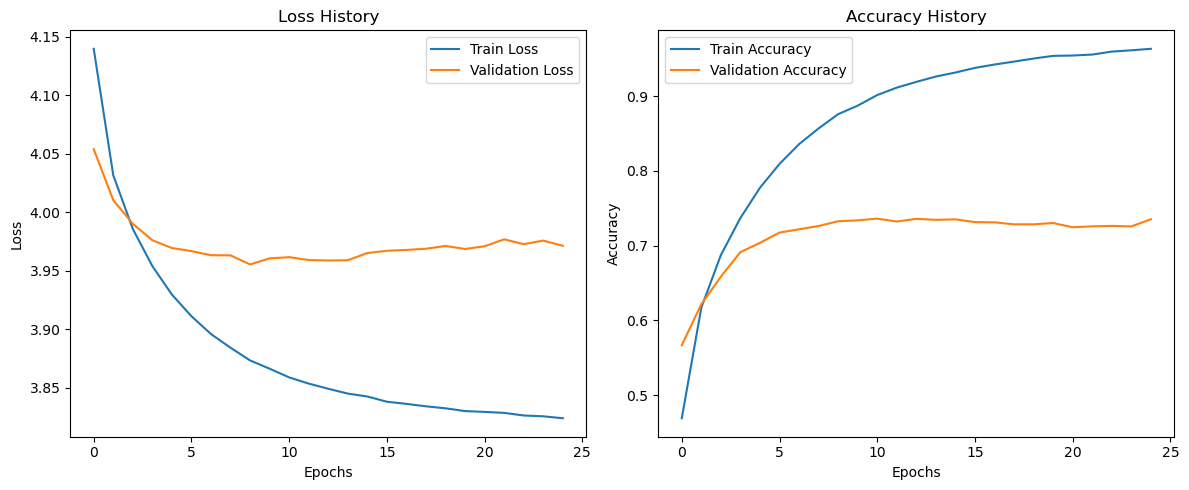


--- Final Evaluation on Test Data ---


Evaluating: 100%|██████████| 354/354 [00:01<00:00, 337.31it/s]

Test Loss: 3.9765 | Test Accuracy: 0.7265


In [38]:
plot_history(history)

print("\n--- Final Evaluation on Test Data ---")
test_loss, test_acc = evaluate(model, test_dataloader, all_text_features, criterion, device)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SharedProjectionModel(image_dim=1024, text_dim=768, projection_dim=256).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = global_clip_loss


class_text_features_list = torch.load('./entry_data/gemini-long.pt')
all_text_features = torch.cat([item['text_features'] for item in class_text_features_list]).to(device)

history = train_model_global(model, train_dataloader, valid_dataloader, all_text_features, optimizer, criterion, num_epochs=17, device=device)

C:\Users\moah\AppData\Local\Temp\ipykernel_22656\599568363.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  class_text_features_list = torch.load('./entry_data/gemini-lon

Epoch 1/17 | Train Loss: 4.1991 | Train Acc: 0.4823 | Val Loss: 4.1168 | Val Acc: 0.5633


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 741.48it/s]


Epoch 2/17 | Train Loss: 4.0971 | Train Acc: 0.6169 | Val Loss: 4.0746 | Val Acc: 0.6359


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 601.74it/s]


Epoch 3/17 | Train Loss: 4.0536 | Train Acc: 0.6901 | Val Loss: 4.0559 | Val Acc: 0.6680


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 542.85it/s]


Epoch 4/17 | Train Loss: 4.0242 | Train Acc: 0.7398 | Val Loss: 4.0439 | Val Acc: 0.6921


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 733.33it/s]


Epoch 5/17 | Train Loss: 4.0012 | Train Acc: 0.7810 | Val Loss: 4.0393 | Val Acc: 0.7116


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 421.90it/s]


Epoch 6/17 | Train Loss: 3.9836 | Train Acc: 0.8164 | Val Loss: 4.0353 | Val Acc: 0.7164


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 385.27it/s]


Epoch 7/17 | Train Loss: 3.9698 | Train Acc: 0.8428 | Val Loss: 4.0305 | Val Acc: 0.7242


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 373.86it/s]


Epoch 8/17 | Train Loss: 3.9584 | Train Acc: 0.8652 | Val Loss: 4.0302 | Val Acc: 0.7259


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 371.23it/s]


Epoch 9/17 | Train Loss: 3.9498 | Train Acc: 0.8826 | Val Loss: 4.0290 | Val Acc: 0.7352


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 375.63it/s]


Epoch 10/17 | Train Loss: 3.9424 | Train Acc: 0.8977 | Val Loss: 4.0340 | Val Acc: 0.7399


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 358.87it/s]


Epoch 11/17 | Train Loss: 3.9363 | Train Acc: 0.9087 | Val Loss: 4.0291 | Val Acc: 0.7379


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 681.00it/s]


Epoch 12/17 | Train Loss: 3.9311 | Train Acc: 0.9186 | Val Loss: 4.0322 | Val Acc: 0.7320


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 621.02it/s]


Epoch 13/17 | Train Loss: 3.9265 | Train Acc: 0.9277 | Val Loss: 4.0332 | Val Acc: 0.7316


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 808.23it/s]


Epoch 14/17 | Train Loss: 3.9233 | Train Acc: 0.9325 | Val Loss: 4.0304 | Val Acc: 0.7369


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 743.44it/s]


Epoch 15/17 | Train Loss: 3.9195 | Train Acc: 0.9393 | Val Loss: 4.0363 | Val Acc: 0.7331


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 820.99it/s]


Epoch 16/17 | Train Loss: 3.9161 | Train Acc: 0.9448 | Val Loss: 4.0345 | Val Acc: 0.7353


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 795.86it/s]

Epoch 17/17 | Train Loss: 3.9143 | Train Acc: 0.9499 | Val Loss: 4.0390 | Val Acc: 0.7328



--- Plotting Training History ---


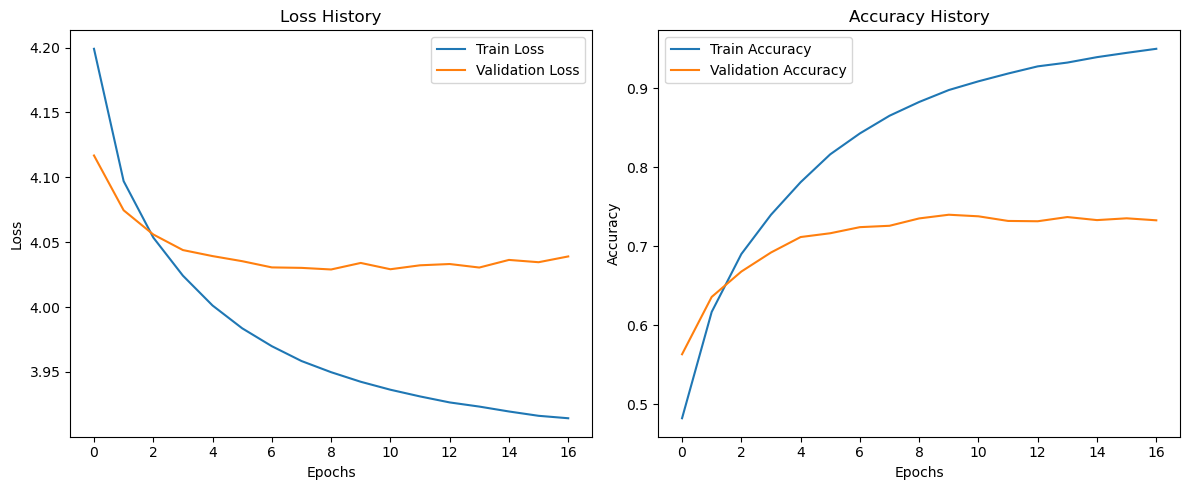


--- Final Evaluation on Test Data ---


Evaluating: 100%|██████████| 354/354 [00:00<00:00, 465.29it/s]

Test Loss: 4.0414 | Test Accuracy: 0.7246


In [46]:
plot_history(history)

print("\n--- Final Evaluation on Test Data ---")
test_loss, test_acc = evaluate(model, test_dataloader, all_text_features, criterion, device)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")